In [0]:
import os
import numpy as np

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.regularizers import l1, l2

Using TensorFlow backend.


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def load_from_drive(name, id):
    module = drive.CreateFile({'id': id})
    module.GetContentFile(name)

file_list = drive.ListFile({'q': "'1CBd-myDP_NKbTovfcwYsam_0H06Bl2Q_' in parents and trashed=false"}).GetList()
for file in file_list:
    if file['title'][-3:] == '.py':
        print("load file: {}, id: {}".format(file['title'], file['id']))
        load_from_drive(file['title'], file['id'])

from ReNetLayer import *
from ReduceImbalance import *
from HilbertLayer import *
from ModifiedReNetLayer import *

load file: ReNetLayer.py, id: 1oohHESF2OGoErRZoEftPAW3m5IXtcwGG
load file: ModifiedReNetLayer.py, id: 11ylcxUGgwS5Yzf_8zRIUzz9a_c--lznh
load file: ReduceImbalance.py, id: 1YG1ZkJfhrJeUNGGruk5iCsCKgK3ukM3H
load file: HilbertLayer.py, id: 1FuFE0OpWp0BFxNFAYGBLmdLXcHkNOSYS
load file: HilbertCurve.py, id: 1ABiyahqt1c1NkR2XIDyfvHyqHeCDkAn8
load file: CommandsGenerator.py, id: 1o4ow1uW7-8cgiAm1fwTF7xyM9piB_ZQ2
load file: ModelIfc.py, id: 1jsKb1mjhEIbAUaFW7BOZ0br8SNGXbr-p
load file: RandomSearch.py, id: 1YXiIrn0osAW4wBBAsYxwAb8BeftQmWyB
load file: KerasAdapter.py, id: 1cTv-dqemRA9j1xgd2TFVUNwtdqXqP3Hk


In [0]:
!pip install kaggle
!mkdir .kaggle
!mkdir ~/.kaggle

import json
token = {"username":"jedrzejkozal","key":"b75eb41911b09455300af4e40d2cb9f0"}
with open('.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
!cp .kaggle/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{.}

- path is now set to: {.}


In [0]:
!mkdir natural_img
!kaggle datasets download -d prasunroy/natural-images -p ./natural_img --force

!unzip natural_img/natural-images.zip -d natural_img/

 99% 169M/171M [00:02<00:00, 83.2MB/s]
100% 171M/171M [00:02<00:00, 75.8MB/s]
Archive:  natural_img/natural-images.zip
   creating: natural_img/natural_images/
   creating: natural_img/natural_images/airplane/
  inflating: natural_img/natural_images/airplane/airplane_0000.jpg  
  inflating: natural_img/natural_images/airplane/airplane_0001.jpg  
  inflating: natural_img/natural_images/airplane/airplane_0002.jpg  
  inflating: natural_img/natural_images/airplane/airplane_0003.jpg  
  inflating: natural_img/natural_images/airplane/airplane_0004.jpg  
  inflating: natural_img/natural_images/airplane/airplane_0005.jpg  
  inflating: natural_img/natural_images/airplane/airplane_0006.jpg  
  inflating: natural_img/natural_images/airplane/airplane_0007.jpg  
  inflating: natural_img/natural_images/airplane/airplane_0008.jpg  
  inflating: natural_img/natural_images/airplane/airplane_0009.jpg  
  inflating: natural_img/natural_images/airplane/airplane_0010.jpg  
  inflating: natural_img/natura

In [0]:
num_samples = 6899
datagen = ImageDataGenerator()
iterator = datagen.flow_from_directory("natural_img/natural_images/", batch_size=num_samples, target_size=(32, 32))
x_data, y_data = next(iterator)
print("before undersampling: ", x_data.shape, y_data.shape)
del datagen
del iterator

num_classes = 8

def normalize(matrix):
    mu = np.mean(matrix, axis=0)
    std = np.std(matrix, axis=0)
    return (matrix - mu) / std

x_data = normalize(x_data)

Found 6899 images belonging to 8 classes.
before undersampling:  (6899, 32, 32, 3) (6899, 8)


In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

x_train, y_train = undersample_to_lowest_cardinality_class(x_data, y_data)
print("after undersampling: ", x_train.shape, y_train.shape)

datagen = ImageDataGenerator(width_shift_range=[-2.0, 0.0, 2.0],
                            horizontal_flip=True,
                            vertical_flip=False)
datagen.fit(x_train)

after undersampling:  (5616, 32, 32, 3) (5616, 8)


In [0]:
def get_reNet(lr=0.001, dense_reg=l1(0.00000001), softmax_reg=l2(0.00000001)):
    model = Sequential()

    reNet_hidden_size = 128
    model.add(ReNetLayer([[2, 2]], reNet_hidden_size,
        use_dropout=True, dropout_rate=0.1))
    model.add(ReNetLayer([[2, 2]], reNet_hidden_size,
        use_dropout=True, dropout_rate=0.1))

    model.add(Flatten())
    fully_conn_hidden_size = 4096
    model.add(Dense(fully_conn_hidden_size, activation='relu', activity_regularizer=dense_reg))
    model.add(Dropout(0.1))

    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=softmax_reg))

    model.compile(loss='categorical_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['categorical_accuracy']
        )
    
    return model

def get_modif_reNet(lr=0.001, dense_reg=l1(0.000000001), softmax_reg=l2(0.000000001), reNet_hidden_size=128, fully_conn_hidden_size=256):
    model = Sequential()
    
    model.add(HilbertLayer())
    model.add(ModifiedReNetLayer(4, reNet_hidden_size,
         use_dropout=True, dropout_rate=0.1))
    model.add(ModifiedReNetLayer(1, reNet_hidden_size,
         use_dropout=True, dropout_rate=0.1))
    model.add(ModifiedReNetLayer(1, reNet_hidden_size,
         use_dropout=True, dropout_rate=0.1))
    model.add(ModifiedReNetLayer(4, reNet_hidden_size,
         use_dropout=True, dropout_rate=0.1))
    model.add(ModifiedReNetLayer(1, reNet_hidden_size,
         use_dropout=True, dropout_rate=0.1))
    model.add(ModifiedReNetLayer(4, reNet_hidden_size,
         use_dropout=True, dropout_rate=0.1))
    model.add(ModifiedReNetLayer(1, reNet_hidden_size,
         use_dropout=True, dropout_rate=0.1))
    

    model.add(Flatten())
    model.add(Dense(fully_conn_hidden_size, activation='relu', activity_regularizer=dense_reg))
    model.add(Dropout(0.1))

    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=softmax_reg))

    model.compile(loss='categorical_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['categorical_accuracy']
        )
    
    return model

def get_conv(lr=0.001, dense_reg=l1(0.00000001), softmax_reg=l2(0.00000001), conv_reg=None):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(4, 4), strides=(1,1), padding='same', activation='relu', kernel_regularizer=conv_reg))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, kernel_size=(2, 2), strides=(1,1), padding='same', activation='relu', kernel_regularizer=conv_reg))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, kernel_size=(4, 4), strides=(1,1), padding='same', activation='relu', kernel_regularizer=conv_reg))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(1024, activation='relu', activity_regularizer=dense_reg))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=softmax_reg))

    model.compile(loss='categorical_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['categorical_accuracy']
        )
    
    return model

In [0]:
model = get_reNet(lr=0.001, dense_reg=l1(0.00000001), softmax_reg=l2(0.00000001))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model = get_modif_reNet()

In [0]:
model = get_conv(lr=0.001, dense_reg=l1(0.00000001), softmax_reg=l2(0.00000001), conv_reg=None)

In [0]:
x_single_ex = x_train[0:1]
y_single_ex = y_train[0:1]
model.fit(x_single_ex, y_single_ex, epochs=1)
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1/1 [==============================] - 12s 12s/step - loss: 2.0687 - categorical_accuracy: 0.0000e+00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
re_net_layer_1 (ReNetLayer)  (None, 16, 16, 256)       0         
_________________________________________________________________
re_net_layer_2 (ReNetLayer)  (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              67112960  
_________________________________________________________________
dropout_9 (Dropout)          (None, 4096)              0         

In [0]:
batch_size = 32
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=20,
        steps_per_epoch=np.ceil(x_train.shape[0] / batch_size),
        validation_data=(x_test, y_test),
        callbacks=[EarlyStopping(monitor='val_loss', patience=20, verbose=1)
            ]
    )

loss, acc = tuple(model.evaluate(x_test, y_test, batch_size=batch_size))
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/20
176/176 [==============================] - 74s 420ms/step - loss: 1.3613 - categorical_accuracy: 0.7351 - val_loss: 0.4974 - val_categorical_accuracy: 0.8899
Epoch 2/20
176/176 [==============================] - 74s 420ms/step - loss: 0.6484 - categorical_accuracy: 0.8338 - val_loss: 0.2703 - val_categorical_accuracy: 0.9179
Epoch 3/20
176/176 [==============================] - 74s 420ms/step - loss: 0.3946 - categorical_accuracy: 0.8725 - val_loss: 0.2491 - val_categorical_accuracy: 0.9338
Epoch 4/20
176/176 [==============================] - 76s 430ms/step - loss: 0.3871 - categorical_accuracy: 0.8794 - val_loss: 0.1751 - val_categorical_accuracy: 0.9396
Epoch 5/20
176/176 [==============================] - 77s 435ms/step - loss: 0.2585 - categorical_accuracy: 0.9146 - val_loss: 0.1583 - val_categorical_accuracy: 0.9478
Epoch 6/20
176/176 [==============================] - 78s 442ms/step - loss: 0.2305 - categorical_accuracy: 0.9201 - val_loss: 0.1583 - val_categorical_acc

In [0]:
x_single_ex = x_train[0:1]
y_single_ex = y_train[0:1]

for hidden_size in [4096]:
    print("fully_conn_hidden_size = ", hidden_size)
    model = get_modif_reNet(reNet_hidden_size=128, fully_conn_hidden_size=hidden_size)
    
    model.fit(x_single_ex, y_single_ex, epochs=1)
    model.summary()
    
    batch_size = 32
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=20,
        steps_per_epoch=np.ceil(x_train.shape[0] / batch_size),
        validation_data=(x_test, y_test),
        callbacks=[EarlyStopping(monitor='val_loss', patience=20, verbose=1)])

    loss, acc = tuple(model.evaluate(x_test, y_test, batch_size=batch_size))
    print("fully_conn_hidden_size = ", hidden_size)
    print("test loss", loss)
    print("test acc: ", acc)

fully_conn_hidden_size =  4096
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1/1 [==============================] - 17s 17s/step - loss: 2.0890 - categorical_accuracy: 0.0000e+00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hilbert_layer_1 (HilbertLaye (None, 1024, 3)           0         
_________________________________________________________________
modified_re_net_layer_1 (Mod (None, 256, 256)          0         
_________________________________________________________________
modified_re_net_layer_2 (Mod (None, 256, 256)          0         
_________________________________________________________________
modified_re_net_layer_3 (Mod (None, 256, 256)          0         
____________________________

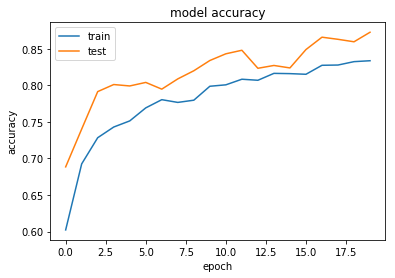

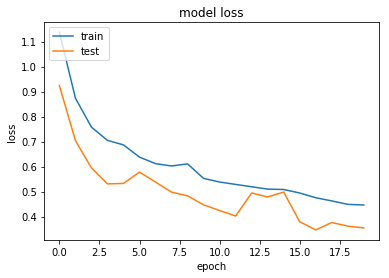

In [0]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Cross validation 5 folds

In [0]:
x, y = x_data, y_data

print("all data: ", x.shape, y.shape)

def get_fold(fold_num):
    fold_num = fold_num-1 #indexing from 0
    x_train = x[train_indexes[fold_num]]
    y_train = y[train_indexes[fold_num]]
    x_test = x[test_indexes[fold_num]]
    y_test = y[test_indexes[fold_num]]

    x_train, y_train = undersample_to_lowest_cardinality_class(x_train, y_train)
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    return x_train, y_train, x_test, y_test

all data:  (6899, 32, 32, 3) (6899, 8)


In [0]:
y = convert_from_one_hot_to_labels(y)

In [0]:
from sklearn.model_selection import StratifiedKFold

def get_splits(x, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    train_indexes = []
    test_indexes = []
    for train_index, test_index in skf.split(x, y):
        print("train_index: ", train_index)
        print("test_index: ", test_index)
        train_indexes.append(train_index)
        test_indexes.append(test_index)
        
    return train_indexes, test_indexes

train_indexes, test_indexes = get_splits(x, y)

train_index:  [   0    1    2 ... 6896 6897 6898]
test_index:  [  12   20   23 ... 6865 6871 6891]
train_index:  [   0    1    2 ... 6896 6897 6898]
test_index:  [   4   14   15 ... 6890 6893 6895]
train_index:  [   0    1    2 ... 6896 6897 6898]
test_index:  [   3    6    8 ... 6883 6884 6892]
train_index:  [   2    3    4 ... 6894 6895 6897]
test_index:  [   0    1    7 ... 6886 6896 6898]
train_index:  [   0    1    3 ... 6895 6896 6898]
test_index:  [   2    5    9 ... 6880 6894 6897]


In [0]:
def test_model_on_fold(model, x_train, y_train, x_test, y_test):
    x_train_single_ex = x_train[0:1]
    y_train_single_ex = y_train[0:1]
    model.fit(x_train_single_ex, y_train_single_ex, epochs=1)
    
    datagen = ImageDataGenerator(width_shift_range=[-2.0, 0.0, 2.0])
    datagen.fit(x_train)

    batch_size = 32
    model.fit(x_train, y_train,
            epochs=50,
            validation_data=(x_test, y_test),
            callbacks=[EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True),
                   ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
            ]
        )
    loss, acc = tuple(model.evaluate(x_test, y_test, batch_size=batch_size))
    return loss, acc

# Fold 1

In [0]:
X_train, Y_train, X_test, Y_test = get_fold(1)

In [0]:
model = get_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 18s 18s/step - loss: 2.0795 - categorical_accuracy: 0.0000e+00
Train on 4488 samples, validate on 1383 samples
Epoch 1/50
4488/4488 [==============================] - 208s 46ms/step - loss: 1.1904 - categorical_accuracy: 0.5862 - val_loss: 0.9413 - val_categorical_accuracy: 0.6753
Epoch 2/50
4488/4488 [==============================] - 203s 45ms/step - loss: 0.8691 - categorical_accuracy: 0.7021 - val_loss: 0.7745 - val_categorical_accuracy: 0.7281
Epoch 3/50
4488/4488 [==============================] - 206s 46ms/step - loss: 0.7314 - categorical_accuracy: 0.7324 - val_loss: 0.8082 - val_categorical_accuracy: 0.7411
Epoch 4/50
4488/4488 [==============================] - 200s 45ms/step - loss: 0.6969 - categorical_accuracy: 0.7493 - val_loss: 0.6769 - val_categorical_accuracy: 0.7643
Epoch 5/50
4488/4488 [==============================] - 197s 44ms/step - loss: 0.6939 - categorical_accuracy: 0.7609 - val_loss: 0.6799 - val_categorical_ac

In [0]:
model = get_modif_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 18s 18s/step - loss: 2.0930 - categorical_accuracy: 0.0000e+00
Train on 4488 samples, validate on 1383 samples
Epoch 1/50
4488/4488 [==============================] - 272s 61ms/step - loss: 1.5031 - categorical_accuracy: 0.4488 - val_loss: 1.2524 - val_categorical_accuracy: 0.5691
Epoch 2/50
4488/4488 [==============================] - 260s 58ms/step - loss: 1.2041 - categorical_accuracy: 0.5619 - val_loss: 1.1409 - val_categorical_accuracy: 0.5973
Epoch 3/50
4488/4488 [==============================] - 260s 58ms/step - loss: 1.0924 - categorical_accuracy: 0.5996 - val_loss: 1.1263 - val_categorical_accuracy: 0.6197
Epoch 4/50
4488/4488 [==============================] - 259s 58ms/step - loss: 1.0373 - categorical_accuracy: 0.6185 - val_loss: 0.9901 - val_categorical_accuracy: 0.6602
Epoch 5/50
4488/4488 [==============================] - 259s 58ms/step - loss: 0.9874 - categorical_accuracy: 0.6446 - val_loss: 1.0042 - val_categorical_ac

In [0]:
model = get_conv()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 4.2656 - categorical_accuracy: 0.0000e+00
Train on 4488 samples, validate on 1383 samples
Epoch 1/50
4488/4488 [==============================] - 59s 13ms/step - loss: 1.3147 - categorical_accuracy: 0.7404 - val_loss: 0.8930 - val_categorical_accuracy: 0.8395
Epoch 2/50
4488/4488 [==============================] - 58s 13ms/step - loss: 0.4805 - categorical_accuracy: 0.8783 - val_loss: 0.4774 - val_categorical_accuracy: 0.8713
Epoch 3/50
4488/4488 [==============================] - 58s 13ms/step - loss: 0.2436 - categorical_accuracy: 0.9234 - val_loss: 0.4172 - val_categorical_accuracy: 0.8901
Epoch 4/50
4488/4488 [==============================] - 58s 13ms/step - loss: 0.1906 - categorical_accuracy: 0.9414 - val_loss: 0.3407 - val_categorical_accuracy: 0.9060
Epoch 5/50
4488/4488 [==============================] - 58s 13ms/step - loss: 0.1725 - categorical_accuracy: 0.9481 - val_loss: 0.5547 - val_categorical_accuracy:

# Fold 2

In [0]:
X_train, Y_train, X_test, Y_test = get_fold(2)

In [0]:
model = get_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 21s 21s/step - loss: 2.0629 - categorical_accuracy: 0.0000e+00
Train on 4488 samples, validate on 1382 samples
Epoch 1/50
4488/4488 [==============================] - 201s 45ms/step - loss: 1.2241 - categorical_accuracy: 0.5773 - val_loss: 0.9330 - val_categorical_accuracy: 0.6643
Epoch 2/50
4488/4488 [==============================] - 193s 43ms/step - loss: 0.8625 - categorical_accuracy: 0.6905 - val_loss: 0.8760 - val_categorical_accuracy: 0.6954
Epoch 3/50
4488/4488 [==============================] - 191s 42ms/step - loss: 0.7634 - categorical_accuracy: 0.7284 - val_loss: 0.7509 - val_categorical_accuracy: 0.7323
Epoch 4/50
4488/4488 [==============================] - 191s 43ms/step - loss: 0.7009 - categorical_accuracy: 0.7522 - val_loss: 0.6608 - val_categorical_accuracy: 0.7533
Epoch 5/50
4488/4488 [==============================] - 195s 43ms/step - loss: 0.6605 - categorical_accuracy: 0.7576 - val_loss: 0.8031 - val_categorical_ac

In [0]:
model = get_modif_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1/1 [==============================] - 11s 11s/step - loss: 2.0906 - categorical_accuracy: 0.0000e+00
Train on 4488 samples, validate on 1382 samples
Epoch 1/50
4488/4488 [==============================] - 223s 50ms/step - loss: 1.5524 - categorical_accuracy: 0.4338 - val_loss: 1.3758 - val_categorical_accuracy: 0.5203
Epoch 2/50
4488/4488 [==============================] - 216s 48ms/step - loss: 1.2860 - categorical_accuracy: 0.5370 - val_loss: 1.2343 - val_categorical_accuracy: 0.5673
Epoch 3/50
4488/4488 [==============================] - 217s 48ms/step - loss: 1.1607 - categorical_accuracy: 0.5816 - val_loss: 1.1383 - val_categorical_accuracy: 0.5962
Epoch 4/50
4488/4488 [==============================] - 216s 48ms/step - loss: 1.0902 - categorical_accuracy: 0.6054 - val_loss: 1.0541 - val_categorical_accuracy: 

In [0]:
model = get_conv()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 6.1133 - categorical_accuracy: 0.0000e+00
Train on 4488 samples, validate on 1382 samples
Epoch 1/50
4488/4488 [==============================] - 59s 13ms/step - loss: 1.2797 - categorical_accuracy: 0.7449 - val_loss: 0.8705 - val_categorical_accuracy: 0.8350
Epoch 2/50
4488/4488 [==============================] - 59s 13ms/step - loss: 0.5886 - categorical_accuracy: 0.8607 - val_loss: 0.5398 - val_categorical_accuracy: 0.8864
Epoch 3/50
4488/4488 [==============================] - 58s 13ms/step - loss: 0.2962 - categorical_accuracy: 0.9149 - val_loss: 0.3518 - val_categorical_accuracy: 0.9038
Epoch 4/50
4488/4488 [==============================] - 58s 13ms/step - loss: 0.2011 - categorical_accuracy: 0.9369 - val_loss: 0.3789 - val_categorical_accuracy: 0.9030
Epoch 5/50
4488/4488 [==============================] - 58s 13ms/step - loss: 0.1360 - categorical_accuracy: 0.9563 - val_loss: 0.4485 - val_categorical_accuracy:

# Fold 3

In [0]:
X_train, Y_train, X_test, Y_test = get_fold(3)

In [0]:
model = get_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 14s 14s/step - loss: 2.0659 - categorical_accuracy: 0.0000e+00
Train on 4496 samples, validate on 1380 samples
Epoch 1/50
4496/4496 [==============================] - 168s 37ms/step - loss: 1.2636 - categorical_accuracy: 0.5770 - val_loss: 0.9624 - val_categorical_accuracy: 0.6674
Epoch 2/50
4496/4496 [==============================] - 163s 36ms/step - loss: 0.8537 - categorical_accuracy: 0.6966 - val_loss: 0.8222 - val_categorical_accuracy: 0.7051
Epoch 3/50
4496/4496 [==============================] - 160s 36ms/step - loss: 0.7415 - categorical_accuracy: 0.7355 - val_loss: 0.7711 - val_categorical_accuracy: 0.7159
Epoch 4/50
4496/4496 [==============================] - 162s 36ms/step - loss: 0.6936 - categorical_accuracy: 0.7496 - val_loss: 0.6477 - val_categorical_accuracy: 0.7783
Epoch 5/50
4496/4496 [==============================] - 160s 36ms/step - loss: 0.6789 - categorical_accuracy: 0.7524 - val_loss: 0.6890 - val_categorical_ac

In [0]:
model = get_modif_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 15s 15s/step - loss: 2.0924 - categorical_accuracy: 0.0000e+00
Train on 4496 samples, validate on 1380 samples
Epoch 1/50
4496/4496 [==============================] - 233s 52ms/step - loss: 1.5589 - categorical_accuracy: 0.4246 - val_loss: 1.3068 - val_categorical_accuracy: 0.5362
Epoch 2/50
4496/4496 [==============================] - 224s 50ms/step - loss: 1.2761 - categorical_accuracy: 0.5492 - val_loss: 1.1442 - val_categorical_accuracy: 0.5848
Epoch 3/50
4496/4496 [==============================] - 223s 50ms/step - loss: 1.1518 - categorical_accuracy: 0.5816 - val_loss: 1.0737 - val_categorical_accuracy: 0.6138
Epoch 4/50
4496/4496 [==============================] - 225s 50ms/step - loss: 1.0874 - categorical_accuracy: 0.6088 - val_loss: 1.0088 - val_categorical_accuracy: 0.6507
Epoch 5/50
4496/4496 [==============================] - 223s 50ms/step - loss: 1.0493 - categorical_accuracy: 0.6214 - val_loss: 0.9853 - val_categorical_ac

In [0]:
model = get_conv()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 2.8335 - categorical_accuracy: 0.0000e+00
Train on 4496 samples, validate on 1380 samples
Epoch 1/50
4496/4496 [==============================] - 56s 12ms/step - loss: 1.3097 - categorical_accuracy: 0.7507 - val_loss: 0.5963 - val_categorical_accuracy: 0.8645
Epoch 2/50
4496/4496 [==============================] - 55s 12ms/step - loss: 0.4668 - categorical_accuracy: 0.8781 - val_loss: 0.5061 - val_categorical_accuracy: 0.8754
Epoch 3/50
4496/4496 [==============================] - 55s 12ms/step - loss: 0.2910 - categorical_accuracy: 0.9157 - val_loss: 0.4241 - val_categorical_accuracy: 0.8942
Epoch 4/50
4496/4496 [==============================] - 54s 12ms/step - loss: 0.2000 - categorical_accuracy: 0.9384 - val_loss: 0.5761 - val_categorical_accuracy: 0.8768
Epoch 5/50
4496/4496 [==============================] - 55s 12ms/step - loss: 0.1763 - categorical_accuracy: 0.9500 - val_loss: 0.7809 - val_categorical_accuracy:

# Fold 4

In [0]:
X_train, Y_train, X_test, Y_test = get_fold(4)

In [0]:
model = get_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 18s 18s/step - loss: 2.0619 - categorical_accuracy: 0.0000e+00
Train on 4496 samples, validate on 1377 samples
Epoch 1/50
4496/4496 [==============================] - 172s 38ms/step - loss: 1.3057 - categorical_accuracy: 0.5629 - val_loss: 1.0341 - val_categorical_accuracy: 0.6558
Epoch 2/50
4496/4496 [==============================] - 163s 36ms/step - loss: 0.8791 - categorical_accuracy: 0.6911 - val_loss: 0.7455 - val_categorical_accuracy: 0.7298
Epoch 3/50
4496/4496 [==============================] - 164s 36ms/step - loss: 0.7545 - categorical_accuracy: 0.7309 - val_loss: 0.7174 - val_categorical_accuracy: 0.7495
Epoch 4/50
4496/4496 [==============================] - 163s 36ms/step - loss: 0.7083 - categorical_accuracy: 0.7478 - val_loss: 0.6821 - val_categorical_accuracy: 0.7524
Epoch 5/50
4496/4496 [==============================] - 161s 36ms/step - loss: 0.6574 - categorical_accuracy: 0.7600 - val_loss: 0.7090 - val_categorical_ac

In [0]:
model = get_modif_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1/1 [==============================] - 13s 13s/step - loss: 2.0960 - categorical_accuracy: 0.0000e+00
Train on 4496 samples, validate on 1377 samples
Epoch 1/50
4496/4496 [==============================] - 227s 51ms/step - loss: 1.5590 - categorical_accuracy: 0.4253 - val_loss: 1.3532 - val_categorical_accuracy: 0.5033
Epoch 2/50
4496/4496 [==============================] - 220s 49ms/step - loss: 1.2956 - categorical_accuracy: 0.5265 - val_loss: 1.2069 - val_categorical_accuracy: 0.5752
Epoch 3/50
4496/4496 [==============================] - 221s 49ms/step - loss: 1.1657 - categorical_accuracy: 0.5801 - val_loss: 1.1098 - val_categorical_accuracy: 0.6020
Epoch 4/50
4496/4496 [==============================] - 223s 50ms/step - loss: 1.0849 - cate

In [0]:
model = get_conv()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 8.9163 - categorical_accuracy: 0.0000e+00
Train on 4496 samples, validate on 1377 samples
Epoch 1/50
4496/4496 [==============================] - 57s 13ms/step - loss: 1.2200 - categorical_accuracy: 0.7502 - val_loss: 0.7353 - val_categorical_accuracy: 0.8395
Epoch 2/50
4496/4496 [==============================] - 56s 13ms/step - loss: 0.4614 - categorical_accuracy: 0.8746 - val_loss: 0.5264 - val_categorical_accuracy: 0.8613
Epoch 3/50
4496/4496 [==============================] - 57s 13ms/step - loss: 0.2991 - categorical_accuracy: 0.9159 - val_loss: 0.5394 - val_categorical_accuracy: 0.8758
Epoch 4/50
4496/4496 [==============================] - 57s 13ms/step - loss: 0.2228 - categorical_accuracy: 0.9295 - val_loss: 0.3944 - val_categorical_accuracy: 0.8969
Epoch 5/50
4496/4496 [==============================] - 57s 13ms/step - loss: 0.1296 - categorical_accuracy: 0.9551 - val_loss: 0.2972 - val_categorical_accuracy:

# Fold 5

In [0]:
X_train, Y_train, X_test, Y_test = get_fold(5)

In [0]:
model = get_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 14s 14s/step - loss: 2.0762 - categorical_accuracy: 0.0000e+00
Train on 4496 samples, validate on 1377 samples
Epoch 1/50
4496/4496 [==============================] - 171s 38ms/step - loss: 1.1712 - categorical_accuracy: 0.5845 - val_loss: 0.8174 - val_categorical_accuracy: 0.7124
Epoch 2/50
4496/4496 [==============================] - 163s 36ms/step - loss: 0.8611 - categorical_accuracy: 0.6951 - val_loss: 0.7897 - val_categorical_accuracy: 0.7030
Epoch 3/50
4496/4496 [==============================] - 164s 36ms/step - loss: 0.7879 - categorical_accuracy: 0.7113 - val_loss: 0.6829 - val_categorical_accuracy: 0.7654
Epoch 4/50
4496/4496 [==============================] - 162s 36ms/step - loss: 0.6948 - categorical_accuracy: 0.7464 - val_loss: 0.6351 - val_categorical_accuracy: 0.7807
Epoch 5/50
4496/4496 [==============================] - 163s 36ms/step - loss: 0.6501 - categorical_accuracy: 0.7647 - val_loss: 0.6152 - val_categorical_ac

In [0]:
model = get_modif_reNet()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 14s 14s/step - loss: 2.0825 - categorical_accuracy: 0.0000e+00
Train on 4496 samples, validate on 1377 samples
Epoch 1/50
4496/4496 [==============================] - 233s 52ms/step - loss: 1.5417 - categorical_accuracy: 0.4364 - val_loss: 1.3200 - val_categorical_accuracy: 0.5410
Epoch 2/50
4496/4496 [==============================] - 222s 49ms/step - loss: 1.2588 - categorical_accuracy: 0.5523 - val_loss: 1.1551 - val_categorical_accuracy: 0.6129
Epoch 3/50
4496/4496 [==============================] - 222s 49ms/step - loss: 1.1434 - categorical_accuracy: 0.5914 - val_loss: 1.0882 - val_categorical_accuracy: 0.6195
Epoch 4/50
4496/4496 [==============================] - 225s 50ms/step - loss: 1.0828 - categorical_accuracy: 0.6108 - val_loss: 1.0066 - val_categorical_accuracy: 0.6412
Epoch 5/50
4496/4496 [==============================] - 224s 50ms/step - loss: 1.0357 - categorical_accuracy: 0.6281 - val_loss: 0.9583 - val_categorical_ac

In [0]:
model = get_conv()

loss, acc = test_model_on_fold(model, X_train, Y_train, X_test, Y_test)
print("test loss", loss)
print("test acc: ", acc)

Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 5.9124 - categorical_accuracy: 0.0000e+00
Train on 4496 samples, validate on 1377 samples
Epoch 1/50
4496/4496 [==============================] - 55s 12ms/step - loss: 1.3409 - categorical_accuracy: 0.7489 - val_loss: 0.7653 - val_categorical_accuracy: 0.8453
Epoch 2/50
4496/4496 [==============================] - 55s 12ms/step - loss: 0.5360 - categorical_accuracy: 0.8630 - val_loss: 0.4680 - val_categorical_accuracy: 0.8940
Epoch 3/50
4496/4496 [==============================] - 54s 12ms/step - loss: 0.3121 - categorical_accuracy: 0.9090 - val_loss: 0.4769 - val_categorical_accuracy: 0.8802
Epoch 4/50
4496/4496 [==============================] - 54s 12ms/step - loss: 0.1793 - categorical_accuracy: 0.9442 - val_loss: 0.3475 - val_categorical_accuracy: 0.9027
Epoch 5/50
4496/4496 [==============================] - 54s 12ms/step - loss: 0.1181 - categorical_accuracy: 0.9591 - val_loss: 0.3433 - val_categorical_accuracy: